# Notebook 3: Model Setup and Evaluation

## Introduction

## Methodology

## Model Preprocessing

### Import Libraries
We begin by importing all the libraries required to run this notebook.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.utils import resample
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, make_scorer

from scripts import function_bank as fl

# the python string package has a helpful punctuation list
import string

import nltk


# Define some default visualizaiton display properties

# Ensure plots are always centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")


### Read in Dataset

We now read in the review dataset that was cleaned in Notebook 2.

In [2]:
df = pd.read_csv('../data/review_data_cleaned.csv')
df.head()

,date,latitude,longitude,review_count,is_open,RestaurantsGoodForGroups,HasTV,GoodForKids,RestaurantsTakeOut,RestaurantsPriceRange2,...,Delis,Specialty Food,stars,useful,funny,cool,text,fans,average_fans_per_user,reviews_per_week
0,2016-03-07 17:58:53,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,4,0,0,0,Pizza here is delicious. I tried it once a few...,0,4.717949,0.057097
1,2014-05-10 11:35:46,42.475805,-70.926544,201,1,1,0,0,1,2,...,0,0,5,0,0,0,Delicious! My co-workers came back from lunch...,0,2.715596,0.353864
2,2014-07-18 14:36:15,42.520691,-70.894220,141,1,1,0,1,1,1,...,0,0,5,0,0,1,I really miss this place. I used to work in S...,0,8.937500,0.190339
3,2010-01-10 17:33:51,42.541155,-70.973438,39,1,1,1,1,1,2,...,0,0,4,1,0,0,love this place! really good pizza and probabl...,0,4.717949,0.057097
4,2012-02-13 05:53:37,42.540409,-71.153318,66,1,1,1,1,1,1,...,0,0,2,5,1,0,"Saw that they won a ""Sandie"" award from Phanto...",0,3.352941,0.109753


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 46 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   date                        1364840 non-null  object 
 1   latitude                    1364840 non-null  float64
 2   longitude                   1364840 non-null  float64
 3   review_count                1364840 non-null  int64  
 4   is_open                     1364840 non-null  int64  
 5   RestaurantsGoodForGroups    1364840 non-null  int64  
 6   HasTV                       1364840 non-null  int64  
 7   GoodForKids                 1364840 non-null  int64  
 8   RestaurantsTakeOut          1364840 non-null  int64  
 9   RestaurantsPriceRange2      1364840 non-null  int64  
 10  RestaurantsReservations     1364840 non-null  int64  
 11  RestaurantsAttire           1364840 non-null  object 
 12  RestaurantsDelivery         1364840 non-null  int64  
 1

### Converting Date Column

We can see that the `date` column is of an object data type. It would be more convenient, if we could extract the individual components of the date as separate numeric columns (e.g. year, month, etc., of the review). To do this, we first convert the `date` column to a `datetime` format and then extract the components of interest. 

In [4]:
df['date'] = pd.to_datetime(df['date'])
df.insert(loc=0, column='Year', value=df['date'].dt.year)
df.insert(loc=1, column='Month', value=df['date'].dt.month)
df.insert(loc=2, column='Day', value=df['date'].dt.day)
df.insert(loc=3, column='Day of Week', value=df['date'].dt.weekday)
df.insert(loc=4, column='Hour', value=df['date'].dt.hour)
df.insert(loc=5, column='Minute', value=df['date'].dt.minute)
df.drop('date', axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1364840 entries, 0 to 1364839
Data columns (total 51 columns):
 #   Column                      Non-Null Count    Dtype  
---  ------                      --------------    -----  
 0   Year                        1364840 non-null  int64  
 1   Month                       1364840 non-null  int64  
 2   Day                         1364840 non-null  int64  
 3   Day of Week                 1364840 non-null  int64  
 4   Hour                        1364840 non-null  int64  
 5   Minute                      1364840 non-null  int64  
 6   latitude                    1364840 non-null  float64
 7   longitude                   1364840 non-null  float64
 8   review_count                1364840 non-null  int64  
 9   is_open                     1364840 non-null  int64  
 10  RestaurantsGoodForGroups    1364840 non-null  int64  
 11  HasTV                       1364840 non-null  int64  
 12  GoodForKids                 1364840 non-null  int64  
 1

We have successfully converted the date components to separate integer columns.

### Ordering the columns

We will be using a column transformer later in this notebook to apply specific transformations to certain columns based on their data type and the information that each contains. Hence, it will be convenient to reorder the columns in a convenient order, based on the order the column transformations will be applied. For now, we will move all columns of the `object` data type to the end of the data frame. 

In [5]:
# Get  columns whose data type is object
object_columns = df.dtypes[df.dtypes == 'object']

# Put the object column names into a list
object_columns = object_columns.index.tolist()
object_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi', 'text']

In [6]:
# Keep the object type columns in a temporary data frame
temp_df = df[object_columns]
temp_df

,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,casual,average,none,no,I really miss this place. I used to work in S...
3,casual,average,none,free,love this place! really good pizza and probabl...
4,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."
...,...,...,...,...,...
1364835,casual,average,beer_and_wine,no,We need restaurants like this to remind us whe...
1364836,casual,average,beer_and_wine,no,Food is good but small portions ! A bit overly...
1364837,casual,average,beer_and_wine,no,I had orders the pasta carbonara for a pick up...
1364838,casual,average,full_bar,no,"As I said, my family and I gave the Jury Room ..."


In [7]:
# Merge the data frame without object columns with the temporary data frame

df = pd.concat([df.drop(columns = object_columns), temp_df], axis=1)
df.head()


,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,funny,cool,fans,average_fans_per_user,reviews_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,0,0,4.717949,0.057097,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,0,0,2.715596,0.353864,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,0,1,0,8.937500,0.190339,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,0,0,4.717949,0.057097,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,1,0,0,3.352941,0.109753,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


### Define X and y

We are now ready to define our independent variable array `X` and our dependent variable `y`. Our dependent variable is the number of stars (i.e. the `stars` column).

In [8]:
X = df.drop(['stars'], axis=1)
X.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,funny,cool,fans,average_fans_per_user,reviews_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
0,2016,3,7,0,17,58,42.541155,-70.973438,39,1,...,0,0,0,4.717949,0.057097,casual,average,none,free,Pizza here is delicious. I tried it once a few...
1,2014,5,10,5,11,35,42.475805,-70.926544,201,1,...,0,0,0,2.715596,0.353864,casual,average,full_bar,free,Delicious! My co-workers came back from lunch...
2,2014,7,18,4,14,36,42.520691,-70.894220,141,1,...,0,1,0,8.937500,0.190339,casual,average,none,no,I really miss this place. I used to work in S...
3,2010,1,10,6,17,33,42.541155,-70.973438,39,1,...,0,0,0,4.717949,0.057097,casual,average,none,free,love this place! really good pizza and probabl...
4,2012,2,13,0,5,53,42.540409,-71.153318,66,1,...,1,0,0,3.352941,0.109753,casual,average,none,no,"Saw that they won a ""Sandie"" award from Phanto..."


In [9]:
y = df['stars']
y.head()

0    4
1    5
2    5
3    4
4    2
Name: stars, dtype: int64

It would be good to view the distribution of our dependent variable.

In [10]:
list(enumerate(y.value_counts().sort_index()))

[(0, 161360), (1, 139469), (2, 192475), (3, 378060), (4, 493476)]

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_27866/65967193.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


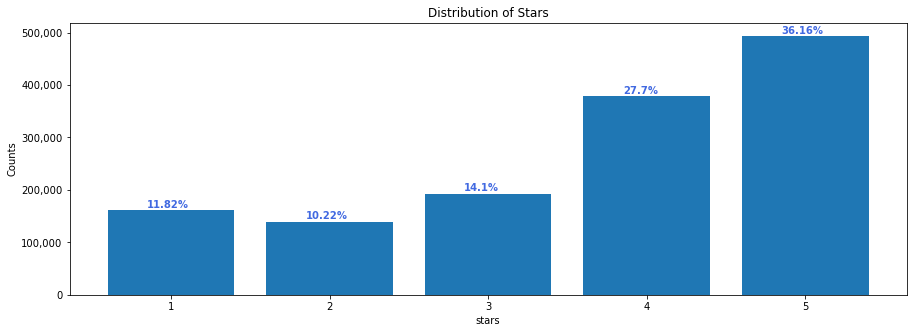

In [11]:
plt.figure(figsize=(15,5))
plt.bar(y.value_counts().sort_index().index.astype('str'),
        y.value_counts().sort_index())
plt.title('Distribution of Stars')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y.value_counts().sort_index()):
    axes.text(i-0.15, j + 5000, str(round(j/X.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

Our distribution is left skewed. However, we do have a reasonable distribution across all the possible number of ratings.

Due to the large dataset (1.3 million reviews) which includes text data, and computing hardware limitations, we will subsample our dataset so that the dataset is more manageable more model training and evaluation. We will use the `resample` method from Scikit-Learn, sampling without replacement, and stratifying based on y. For this project, we will utilize around 13,000 reviews (~1% of the original dataset).

In [12]:
X_sampled, y_sampled = resample(X, y, random_state=0, 
                                    n_samples = 0.01*X.shape[0],
                                    replace=False, stratify=y)

In [13]:
print(f'X_sampled shape: {X_sampled.shape}')
print(f'y_sampled shape: {y_sampled.shape}')

X_sampled shape: (13648, 50)
y_sampled shape: (13648,)


Our sampled dataset has 13,648 rows and 50 columns. Let's take a look at the distribution of our dependent variable in this sample.

/var/folders/mj/wygw49hn45s4xjsgwgykrkc40000gn/T/ipykernel_27866/1967618503.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


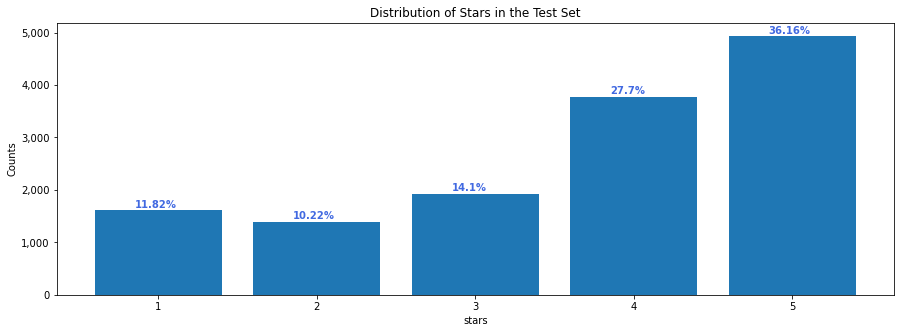

In [14]:
plt.figure(figsize=(15,5))
plt.bar(y_sampled.value_counts().sort_index().index.astype('str'),
        y_sampled.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')

axes = plt.gca()
axes.set_axisbelow(True)

for i, j in enumerate(y_sampled.value_counts().sort_index()):
    axes.text(i-0.15, j + 50, str(round(j/X_sampled.shape[0]*100,2))+'%', color='royalblue', fontweight='bold')

current_values = axes.get_yticks()
axes.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
plt.show()

The stratification worked as intended, since our dependent variable distribution in this sample is very similar to its distribution in the overall dataset.

In [15]:
X_sampled.columns

Index(['Year', 'Month', 'Day', 'Day of Week', 'Hour', 'Minute', 'latitude',
       'longitude', 'review_count', 'is_open', 'RestaurantsGoodForGroups',
       'HasTV', 'GoodForKids', 'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'RestaurantsReservations', 'RestaurantsDelivery', 'OutdoorSeating',
       'BusinessAcceptsCreditCards', 'Sandwiches', 'Nightlife', 'Pizza',
       'Bars', 'American (Traditional)', 'American (New)', 'Italian',
       'Breakfast & Brunch', 'Coffee & Tea', 'Chinese', 'Seafood', 'Burgers',
       'Fast Food', 'Salad', 'Cafes', 'Mexican', 'Bakeries', 'Japanese',
       'Delis', 'Specialty Food', 'useful', 'funny', 'cool', 'fans',
       'average_fans_per_user', 'reviews_per_week', 'RestaurantsAttire',
       'NoiseLevel', 'Alcohol', 'WiFi', 'text'],
      dtype='object')

### Check Correlation with Number of stars

In [16]:
def correlation_coeff(X, y):
    
    correlation_df = pd.DataFrame(columns=['Variable', 'Correlation Coefficient', 'p-value'])
    
    for column in X.columns:
        corr_coef, p_value = stats.pearsonr(X[column], y)
        correlation_df = correlation_df.append({'Variable': column,
                                                'Correlation Coefficient': corr_coef,
                                                'p-value': p_value}, ignore_index=True)
        correlation_df.sort_values(by='Correlation Coefficient', ascending=False, inplace=True)
    
    return correlation_df


### Check for Multicollinearity

In [17]:
'''def high_correlation(x, color):
    threshold = 0.5
    return f'color: {color};' if x < -1*(threshold) or x > threshold else None

X.corr().style.applymap(high_correlation, color='red')'''

"def high_correlation(x, color):\n    threshold = 0.5\n    return f'color: {color};' if x < -1*(threshold) or x > threshold else None\n\nX.corr().style.applymap(high_correlation, color='red')"

In [18]:
# plt.figure(figsize=(20,15))
# mask = np.triu(np.ones_like(X.corr()))

# sns.heatmap(X.corr(), cmap='coolwarm', mask=mask, vmin=-1, vmax=1)
# plt.show()

## Modelling

### Defining Train and Test Sets

In [19]:
# Splitting out 20% for test set
X_train, X_test, y_train, y_test = train_test_split(X_sampled, y_sampled, test_size = 0.2, stratify=y_sampled, random_state=0)

print(f'Shape of X_train: {X_train.shape}. Shaper of y_train: {y_train.shape}')
print(f'Shape of X_test: {X_test.shape}. Shaper of y_test: {y_test.shape}')

Shape of X_train: (10918, 50). Shaper of y_train: (10918,)
Shape of X_test: (2730, 50). Shaper of y_test: (2730,)


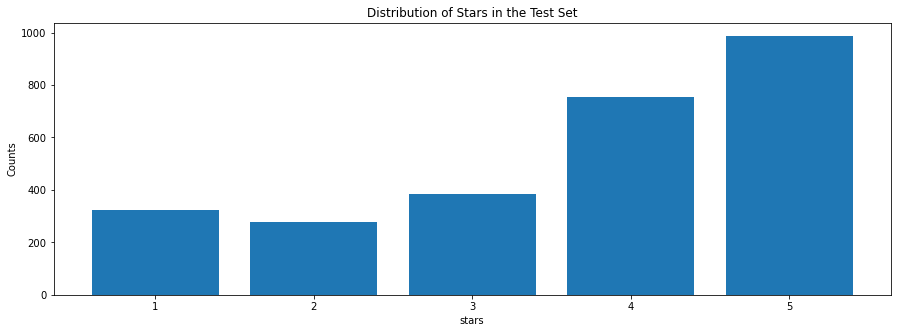

In [20]:
plt.figure(figsize=(15,5))
plt.bar(y_test.value_counts().sort_index().index.astype('str'),
        y_test.value_counts().sort_index())
plt.title('Distribution of Stars in the Test Set')
plt.xlabel('stars')
plt.ylabel('Counts')
plt.show()

In [21]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10918 entries, 118838 to 910818
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Year                        10918 non-null  int64  
 1   Month                       10918 non-null  int64  
 2   Day                         10918 non-null  int64  
 3   Day of Week                 10918 non-null  int64  
 4   Hour                        10918 non-null  int64  
 5   Minute                      10918 non-null  int64  
 6   latitude                    10918 non-null  float64
 7   longitude                   10918 non-null  float64
 8   review_count                10918 non-null  int64  
 9   is_open                     10918 non-null  int64  
 10  RestaurantsGoodForGroups    10918 non-null  int64  
 11  HasTV                       10918 non-null  int64  
 12  GoodForKids                 10918 non-null  int64  
 13  RestaurantsTakeOut       

### Column Transformer

In [22]:
numeric_columns = X_train.dtypes[df.dtypes != 'object'].index.to_list()
numeric_columns

['Year',
 'Month',
 'Day',
 'Day of Week',
 'Hour',
 'Minute',
 'latitude',
 'longitude',
 'review_count',
 'is_open',
 'RestaurantsGoodForGroups',
 'HasTV',
 'GoodForKids',
 'RestaurantsTakeOut',
 'RestaurantsPriceRange2',
 'RestaurantsReservations',
 'RestaurantsDelivery',
 'OutdoorSeating',
 'BusinessAcceptsCreditCards',
 'Sandwiches',
 'Nightlife',
 'Pizza',
 'Bars',
 'American (Traditional)',
 'American (New)',
 'Italian',
 'Breakfast & Brunch',
 'Coffee & Tea',
 'Chinese',
 'Seafood',
 'Burgers',
 'Fast Food',
 'Salad',
 'Cafes',
 'Mexican',
 'Bakeries',
 'Japanese',
 'Delis',
 'Specialty Food',
 'useful',
 'funny',
 'cool',
 'fans',
 'average_fans_per_user',
 'reviews_per_week']

In [23]:
categorical_columns = X_train.drop('text', axis=1).dtypes[df.dtypes == 'object'].index.to_list()
categorical_columns

['RestaurantsAttire', 'NoiseLevel', 'Alcohol', 'WiFi']

In [24]:
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [25]:
# import the nltk stopwords
nltk.download('stopwords')
from nltk.corpus import stopwords 

ENGLISH_STOP_WORDS = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/allistaircota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [26]:
ENGLISH_STOP_WORDS = stopwords.words('english')

# Let's test it out
stemmer = nltk.stem.PorterStemmer()

def my_tokenizer(sentence):
    # remove punctuation and set to lower case
    for punctuation_mark in string.punctuation:
        sentence = sentence.replace(punctuation_mark,'').lower()

    # split sentence into words
    listofwords = sentence.split(' ')
    listofstemmed_words = []
    
    # remove stopwords and any tokens that are just empty strings
    for word in listofwords:
        if (not word in ENGLISH_STOP_WORDS) and (word!=''):
            # Stem words
            stemmed_word = stemmer.stem(word)
            listofstemmed_words.append(stemmed_word)

    return listofstemmed_words

In [27]:
sentence = "The quick brown fox, jumped over the lazy dog!!"

my_tokenizer(sentence)

['quick', 'brown', 'fox', 'jump', 'lazi', 'dog']

In [28]:
%%time

# full_pipeline = ColumnTransformer([
#     ('num', MinMaxScaler(), numeric_columns),
#     ('cat', OneHotEncoder(drop='first'), categorical_columns),
#     ('review', ReviewTextTransformer(), 'text')
# ])

col_trans = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', CountVectorizer(tokenizer=my_tokenizer, min_df=25), 'text')
])

CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 27.9 µs


In [29]:
col_trans.fit(X_train)
temp_df = col_trans.transform(X_train).todense()
temp_df = pd.DataFrame(columns=col_trans.get_feature_names_out(), data=temp_df, index=X_train.index)
X_train_unscaled = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

temp_df = col_trans.transform(X_test).todense()
temp_df = pd.DataFrame(columns=col_trans.get_feature_names_out(), data=temp_df, index=X_test.index)
X_test_unscaled = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

In [30]:
col_trans.get_feature_names_out()

array(['cat__RestaurantsAttire_dressy', 'cat__NoiseLevel_loud',
       'cat__NoiseLevel_quiet', ..., 'review__yummi', 'review__zero',
       'review__zucchini'], dtype=object)

In [31]:
X_train_unscaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,350,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,67,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,428,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,251,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,325,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [32]:
X_test_unscaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,138,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,395,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,635,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,671,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,102,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [33]:
scaler = MinMaxScaler()

# Fit the scaler to X_rem and transform X_rem
X_train_scaled = scaler.fit_transform(X_train_unscaled)

# Transform X_test using the fitted scaler
X_test_scaled= scaler.transform(X_test_unscaled)

# Redefine numpy arrays as dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_unscaled.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_unscaled.columns)

# Print shapes
print(f'Shape of scaled remainder set: {X_train_scaled.shape}')
print(f'Shape of scaled test set: {X_test_scaled.shape}')

Shape of scaled remainder set: (10918, 2299)
Shape of scaled test set: (2730, 2299)


In [34]:
X_train_scaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.3125,0.909091,0.200000,1.0,0.521739,0.728814,0.586507,0.001951,0.047306,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.8125,0.818182,0.100000,0.5,0.608696,0.135593,0.503246,0.002397,0.008501,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.9375,0.636364,0.266667,1.0,0.043478,0.322034,0.478006,0.002232,0.058001,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.1875,0.545455,0.533333,0.5,0.000000,0.288136,0.524001,0.002089,0.033731,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8750,0.000000,1.000000,0.5,0.869565,0.847458,0.439284,0.001572,0.043878,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
X_test_scaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
0,0.8750,0.272727,0.666667,1.000000,0.956522,0.593220,0.475821,0.002164,0.018237,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.9375,0.000000,0.366667,1.000000,0.086957,0.525424,0.693166,0.001199,0.053476,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4375,0.545455,0.233333,1.000000,0.086957,0.949153,0.570383,0.001972,0.086384,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.6250,1.000000,0.466667,0.166667,0.043478,0.474576,0.514237,0.002389,0.091320,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.3750,0.636364,0.833333,0.666667,0.826087,0.067797,0.555869,0.002142,0.013300,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
X_train.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,funny,cool,fans,average_fans_per_user,reviews_per_week,RestaurantsAttire,NoiseLevel,Alcohol,WiFi,text
118838,2010,11,7,6,12,43,42.395293,-71.121620,350,1,...,0,0,20,9.604972,0.449520,casual,average,beer_and_wine,no,I've been waiting for the longest time to chec...
984277,2018,10,4,3,14,8,42.353567,-71.058031,67,1,...,0,0,0,9.179104,0.377504,casual,average,beer_and_wine,free,Great service and a very nice vibe to the plac...
778602,2020,8,9,6,1,19,42.340918,-71.081615,428,1,...,0,0,0,14.026846,1.700533,dressy,average,full_bar,no,"Wow, what a treat! Friends raved about this re..."
483464,2008,7,17,3,0,17,42.363968,-71.101869,251,0,...,0,0,7,16.387352,0.324529,casual,average,full_bar,no,"You know, for how pricey the food is, I'm surp..."
496132,2019,1,31,3,20,50,42.321512,-71.175672,325,1,...,0,0,0,3.878698,1.035773,casual,average,full_bar,free,It's my favorite place for a special dinner I ...


In [37]:
# encoded_columns1 = full_pipeline.transformers_[1][1].get_feature_names_out()
# encoded_columns1

In [38]:
# encoded_columns2 = full_pipeline.transformers_[2][1].get_feature_names_out()
# encoded_columns2
# # clf.named_steps['preprocessor'].transformers_[1][1]\
# #    .named_steps['onehot'].get_feature_names(categorical_features)

In [39]:
print(type(numeric_columns))
len(numeric_columns)

<class 'list'>


45

In [40]:
# columns = np.concatenate([numeric_columns, encoded_columns1, encoded_columns2])
# columns.shape

In [41]:
# X_train_scaled = pd.DataFrame(columns=columns,data=temp_df)
# print(X_train_scaled.shape)
# X_train_scaled.head()

In [42]:
# X_train_scaled.iloc[:5, 45:60]

In [43]:
# X_train.head()

In [44]:
# temp_df = full_pipeline.transform(X_test).todense()
# temp_df.shape

In [45]:
# X_test_scaled = pd.DataFrame(columns=columns,data=temp_df)
# print(X_test_scaled.shape)
# X_test_scaled.head()

In [46]:
# X_test_scaled.head()

### Defining Custom Scoring Functions

In [47]:
def bound_predict(y_pred):
    y_pred = np.where(y_pred > 5, 5, y_pred)
    y_pred = np.where(y_pred < 1, 1, y_pred)
    return y_pred

In [48]:
def custom_mae_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return mean_absolute_error(y_true, y_pred)

def custom_r2_scorer_func(y_true, y_pred):
    y_pred = bound_predict(y_pred)
    return r2_score(y_true, y_pred)

custom_mae_scorer = make_scorer(custom_mae_scorer_func, greater_is_better=False)
custom_r2_scorer = make_scorer(custom_r2_scorer_func, greater_is_better=True)

scorer = {'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
          'custom_r2_scorer': make_scorer(custom_r2_scorer_func, greater_is_better=True)}

### Dummy Model

In [49]:
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_test_scaled, y_test)

DummyRegressor()

In [50]:
prediction = dummy_reg.predict(X_test_scaled)
mean_absolute_error(y_test, prediction)

1.1557340095801636

In [51]:
custom_mae_scorer_func(y_test, prediction)

1.1557340095801636

### Linear Regression

#### Default Parameters

In [52]:
%%time
# Define the model
lin_reg = LinearRegression()

# Cross validation score
# scores = cross_validate(lin_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('custom_mae_scorer', 'custom_r2_scorer', 'r2'))

scores = cross_validate(lin_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

CPU times: user 5min 41s, sys: 15.6 s, total: 5min 57s
Wall time: 38.5 s


In [53]:
scores

{'fit_time': array([7.89955211, 7.58243704, 7.94271684, 7.74817085, 7.13500595]),
 'score_time': array([0.02330589, 0.02205706, 0.02975321, 0.02034903, 0.02021694]),
 'test_custom_mae_scorer': array([-0.76372185, -0.77400578, -0.76263678, -0.74664564, -0.76812259]),
 'test_custom_r2_scorer': array([0.46901302, 0.45719674, 0.48465172, 0.47051825, 0.4534098 ])}

In [54]:
print('MAE Score:')
print(-scores['test_custom_mae_scorer'])
print(np.mean(-scores['test_custom_mae_scorer']))
print('\n')

print('R^2 Score:')
print(scores['test_custom_r2_scorer'])
print(np.mean(scores['test_custom_r2_scorer']))

MAE Score:
[0.76372185 0.77400578 0.76263678 0.74664564 0.76812259]
0.7630265289314453


R^2 Score:
[0.46901302 0.45719674 0.48465172 0.47051825 0.4534098 ]
0.46695790474628707


In [55]:
# # Evaluate the model
# lin_reg.fit(X_train, y_train)

# prediction = lin_reg.predict(X_test)

# print(f'The R^2 score is: {r2_score(y_test, prediction)}')
# print(f'The MAE is: {mean_absolute_error(y_test, prediction)}')

In [56]:
# fitted_values = lin_reg.predict(X_train)
# residuals = (y_train - fitted_values)

# plt.figure(figsize=(15,10))
# plt.scatter(fitted_values, residuals)
# plt.xlabel('Fitted Values')
# plt.ylabel('Residuals')
# plt.title('Residual Plot', fontsize=20)
# plt.show()

#### Adding L2 Regularization

In [57]:
# # Define the model
# ridge_reg = Ridge(alpha=1.0)

# # Cross validation score
# scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'))

# print('MAE Score:')
# print(-scores['test_neg_mean_absolute_error'])
# print(np.mean(-scores['test_neg_mean_absolute_error']))
# print('\n')


# print('R^2 Score:')
# print(scores['test_r2'])
# print(np.mean(scores['test_r2']))

In [58]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-4, 4, 1):
    alpha = 10**power
    ridge_reg = Ridge(alpha=alpha)

    
    cv_scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores
    

CPU times: user 4min 45s, sys: 14 s, total: 4min 59s
Wall time: 29.7 s


,alpha,MAE,R-squared
0,0.0001,0.763029,0.466960
1,0.0010,0.763028,0.467058
2,0.0100,0.762673,0.467748
3,0.1000,0.759523,0.473543
4,1.0000,0.742366,0.504841
5,10.0000,0.733272,0.535033
6,100.0000,0.833792,0.429761
7,1000.0000,1.042555,0.162623


In [59]:
def regression_plots(scores, model_description):
    plt.subplots(1,2, figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(scores['alpha'], scores['MAE'], label='Mean Absolute Error', color='orange')
    plt.xscale('log')
    plt.legend()
    plt.title('MAE Variation with ' + model_description)
    plt.xlabel('Alpha')


#     plt.subplot(1,3,2)
#     plt.plot(scores['alpha'], scores['RMSE'], label='Root Mean Squared Error', color='blue')
#     plt.xscale('log')
#     plt.legend()
#     plt.title('RMSE variation with ' + model_description)
#     plt.xlabel('Alpha')

    plt.subplot(1,2,2)
    plt.plot(scores['alpha'], scores['R-squared'], label='R^2', color='green')
    plt.xscale('log')
    plt.legend()
    plt.title('R^2 variation with ' + model_description)
    plt.xlabel('Alpha')

    plt.tight_layout()
    plt.show()
    

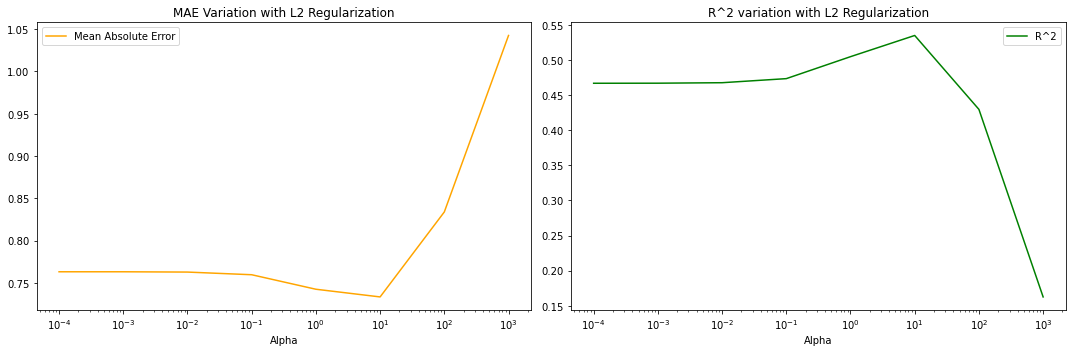

In [60]:
regression_plots(scores, 'L2 Regularization')

In [61]:
def plot_fitted_values(fitted_values, y, model_description):
    plt.figure(figsize=(10,5))
    plt.scatter(fitted_values, y, alpha=0.1)
    plt.title('Fitted versus Actual Values for ' + model_description)
    plt.xlabel('Fitted Values')
    plt.ylabel('Actual Values')

plt.show()
    

In [62]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled))
print(custom_mae_scorer_func(y_train, fitted_values))
print(custom_r2_scorer_func(y_train, fitted_values))

0.6498059600280648
0.6304765532110117


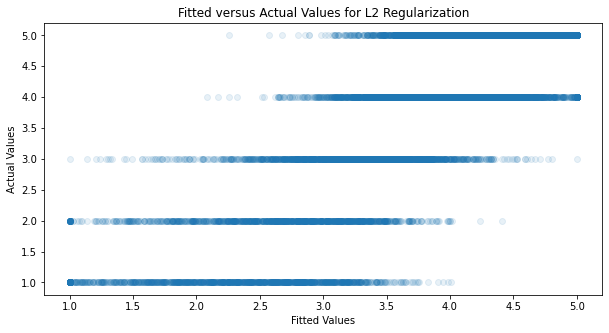

In [63]:
plot_fitted_values(fitted_values, y_train, 'L2 Regularization')

0.7284570450113259
0.5328996207391679


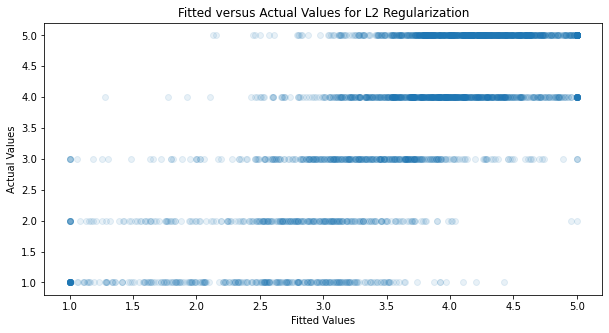

In [64]:
fitted_values = bound_predict(ridge_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L2 Regularization')

In [65]:
# residuals = ridge_reg.predict(X_train_scaled) - y_train

In [66]:
# def plot_residuals(X_train, residuals):
#     num_rows = int(np.ceil(X_train.shape[1]/4))
#     plt.subplots(num_rows, 4, figsize=(15,20))
    
#     for i in range(0, X_train.shape[1]):
#         plt.subplot(num_rows, 4, i+1)
#         plt.scatter(X_train.iloc[:,i], residuals, alpha=0.1)
#         plt.xlabel(X_train.columns[i])
        
    
#     plt.tight_layout()
#     plt.show()
                 
                 

In [67]:
#plot_residuals(X_train, residuals)

#### Adding L1 Regularization

In [68]:
# # Define the model
# lasso_reg = Lasso(alpha=1.0)

# # Cross validation score
# scores = cross_validate(lasso_reg, X_train_scaled, y_train, cv=5,
#                                scoring=('neg_mean_absolute_error', 'neg_mean_squared_error', 'r2'))

# print('MAE Score:')
# print(-scores['test_neg_mean_absolute_error'])
# print(np.mean(-scores['test_neg_mean_absolute_error']))
# print('\n')


# print('R^2 Score:')
# print(scores['test_r2'])
# print(np.mean(scores['test_r2']))

In [69]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-4, 4, 1):
    alpha = 10**power
    lasso_reg = Lasso(alpha=alpha)

    
    cv_scores = cross_validate(lasso_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

CPU times: user 4min 32s, sys: 14.1 s, total: 4min 46s
Wall time: 48.2 s


,alpha,MAE,R-squared
0,0.0001,0.732567,0.521689
1,0.0010,0.752144,0.514330
2,0.0100,0.995499,0.232128
3,0.1000,1.155397,-0.000224
4,1.0000,1.155397,-0.000224
5,10.0000,1.155397,-0.000224
6,100.0000,1.155397,-0.000224
7,1000.0000,1.155397,-0.000224


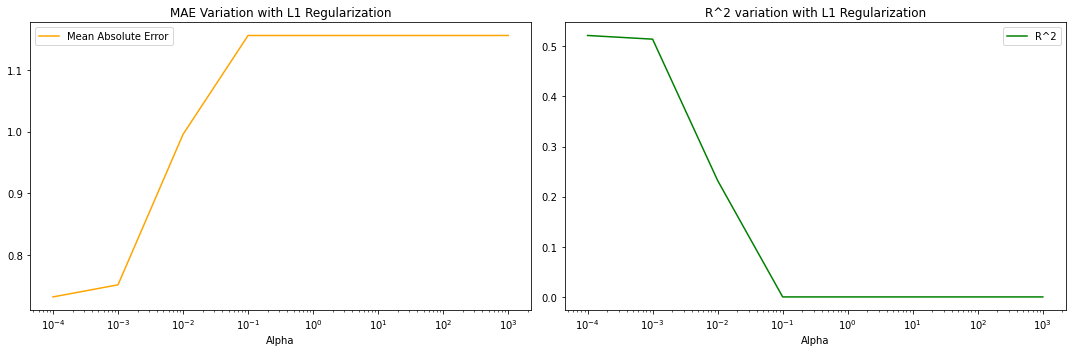

In [70]:
regression_plots(scores, 'L1 Regularization')

0.7311139418132043
0.5418357787531771


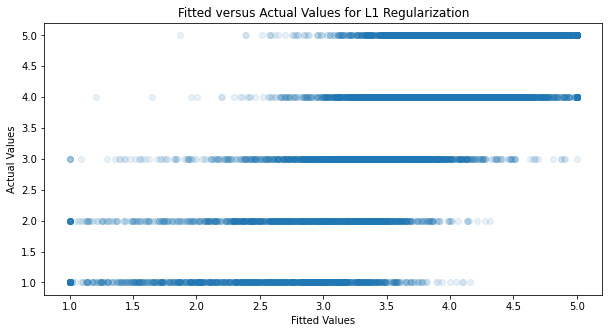

In [71]:
final_lasso_reg = Lasso(alpha=10**(-3))
final_lasso_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(final_lasso_reg.predict(X_train_scaled))
print(mean_absolute_error(y_train, fitted_values))
print(r2_score(y_train, fitted_values))
plot_fitted_values(fitted_values, y_train, 'L1 Regularization')

0.7462326196545936
0.5195970651071462


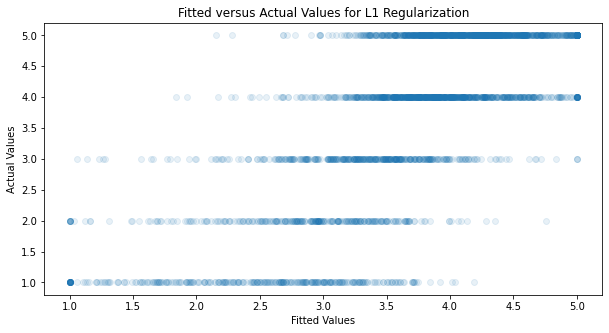

In [72]:
fitted_values = bound_predict(final_lasso_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L1 Regularization')

#### Most Predictive Words

In [73]:
tokens = [column for column in X_train_scaled.columns if 'review__' in column]
len(tokens)

2246

In [74]:
first_token_index = X_train_scaled.columns.get_loc(tokens[0])
first_token_index

53

In [75]:
token_coef_df = pd.DataFrame({'coefficient': [ridge_reg.coef_[i] for i in range(first_token_index,
                                                                                      X_train_scaled.shape[1],1)],
                             'token': pd.Series(tokens).str.replace('review__', '')}).sort_values("coefficient", ascending=False)

token_coef_df.head()

,coefficient,token
257,1.637508,best
935,1.491703,great
129,1.234554,amaz
753,1.132329,excel
603,1.065847,delici


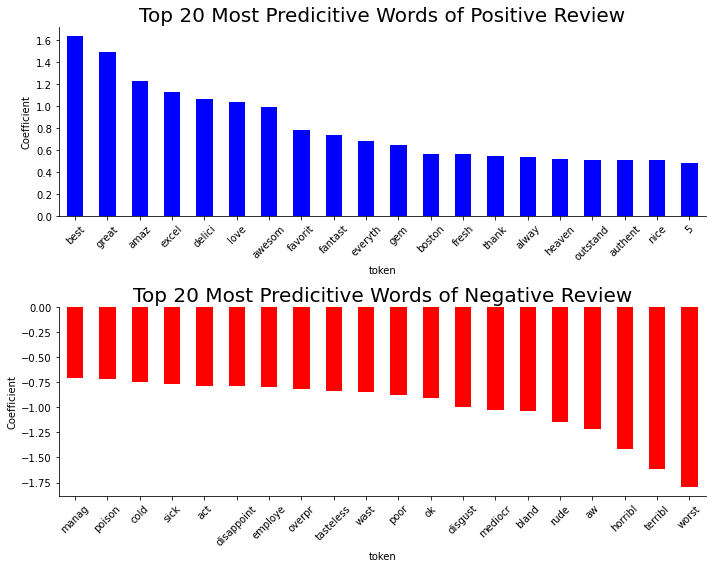

In [76]:
# Plot the top 20 most predictive words
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Most predictive words of a positive review
token_coef_df.head(20).set_index("token").plot(kind="bar", rot=45, ax=ax[0], color="blue", legend=False)
ax[0].set_title("Top 20 Most Predicitive Words of Positive Review", fontsize=20)
ax[0].set_ylabel('Coefficient')

# Most predictive words of a negative review
token_coef_df.tail(20).set_index("token").plot(kind="bar", rot=45, ax=ax[1], color="red", legend=False)
ax[1].set_title("Top 20 Most Predicitive Words of Negative Review", fontsize=20)
ax[1].set_ylabel('Coefficient')

sns.despine()
plt.tight_layout()
plt.show()

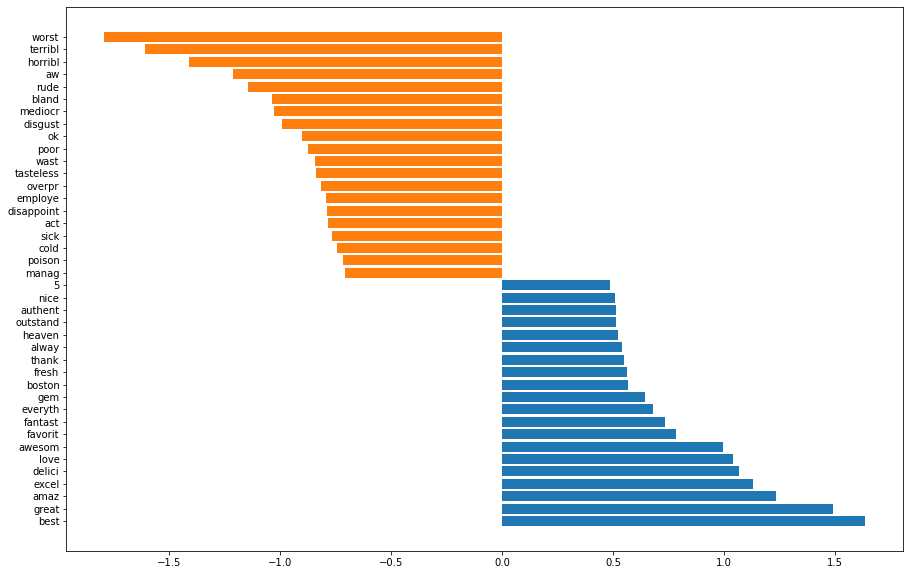

In [77]:
plt.figure(figsize=(15,10))
plt.barh(token_coef_df['token'].head(20),token_coef_df.head(20)["coefficient"])
plt.barh(token_coef_df['token'].tail(20),token_coef_df.tail(20)["coefficient"])

plt.show()

In [78]:
%%time

# full_pipeline = ColumnTransformer([
#     ('num', MinMaxScaler(), numeric_columns),
#     ('cat', OneHotEncoder(drop='first'), categorical_columns),
#     ('review', ReviewTextTransformer(), 'text')
# ])

tfidf_pipeline = ColumnTransformer([
    ('num', MinMaxScaler(), numeric_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', CountVectorizer(stop_words= 'english', min_df=10), 'text')
])

tfidf_pipeline.fit(X_train)
temp_df = tfidf_pipeline.transform(X_train).todense()

CPU times: user 1.41 s, sys: 117 ms, total: 1.53 s
Wall time: 1.53 s


### Decision Tree

In [67]:
DT_model = DecisionTreeRegressor(max_depth=25, min_samples_leaf=10, random_state=0)
DT_model.fit(X_train_scaled, y_train)

print(mean_absolute_error(y_train, DT_model.predict(X_train_scaled)))
print(r2_score(y_train, DT_model.predict(X_train_scaled)))

0.6308462879217522
0.5986353600699075


0.8719392786106255
0.2689292754202337


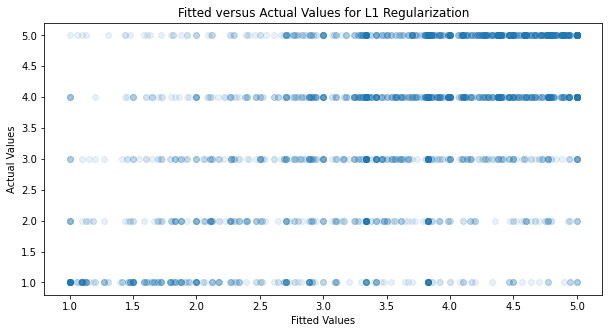

In [68]:
fitted_values = DT_model.predict(X_test_scaled)
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'L1 Regularization')

In [64]:
DT_model.get_depth()

78

In [63]:
# residuals = DT_model.predict(X_train) - y_train

# plot_residuals(X_train, residuals)

In [69]:
%%time

DT_model = DecisionTreeRegressor(min_samples_leaf=2, random_state=0)

# Cross validation score
scores = cross_validate(DT_model, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

print('MAE Score:')
print(-scores['test_custom_mae_scorer'])
print(np.mean(-scores['test_custom_mae_scorer']))
print('\n')


print('R^2 Score:')
print(scores['test_custom_r2_scorer'])
print(np.mean(scores['test_custom_r2_scorer']))


MAE Score:
[0.89934371 0.94398657 0.96039377 0.89143381 0.94655673]
0.9283429173259682


R^2 Score:
[ 0.05919403 -0.00530444 -0.01732993  0.09164852 -0.00296373]
0.025048890064847295


In [40]:
%%time

DT_reg = DecisionTreeRegressor()

param_grid = [{'max_depth': [25, 50, 70], 'min_samples_leaf': [2, 4, 6]}]

grid_search = GridSearchCV(DT_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer')

grid_search.fit(X_train_scaled, y_train)

CPU times: user 2min 35s, sys: 2.9 s, total: 2min 38s
Wall time: 2min 38s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid=[{'max_depth': [25, 50, 70],
                          'min_samples_leaf': [2, 4, 6]}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)})

In [41]:
grid_search.best_params_

{'max_depth': 25, 'min_samples_leaf': 6}

In [42]:
best_DT_reg = grid_search.best_estimator_
best_DT_reg

DecisionTreeRegressor(max_depth=25, min_samples_leaf=6)

0.5534225392864824
0.6680304266679891


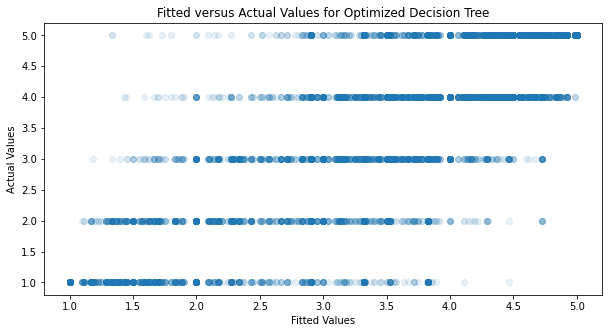

In [77]:
best_DT_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(best_DT_reg.predict(X_train_scaled))
print(mean_absolute_error(y_train, fitted_values))
print(r2_score(y_train, fitted_values))
plot_fitted_values(fitted_values, y_train, 'Optimized Decision Tree')

0.8702423732322755
0.2542343623505233


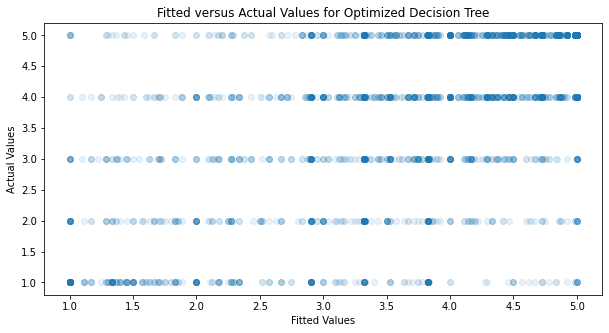

In [78]:
fitted_values = bound_predict(best_DT_reg.predict(X_test_scaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'Optimized Decision Tree')

### Random Forest

In [39]:
%%time

scores = pd.DataFrame(columns=['n_estimators', 'MAE', 'R-squared'])

for n in range(100, 102, 25):
    forest_reg = RandomForestRegressor(n_estimators=n, max_depth = 25, min_samples_leaf = 6)

    
    cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'n_estimators': n,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores



CPU times: user 14min 2s, sys: 1.77 s, total: 14min 3s
Wall time: 14min 4s


,n_estimators,MAE,R-squared
0,100.0,0.778179,0.472862


### TF-IDF Vectorizer

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [80]:
col_trans_2 = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_columns),
    ('review', TfidfVectorizer(min_df=25, tokenizer=my_tokenizer), 'text')
])

In [81]:
col_trans_2.fit(X_train)
temp_df = col_trans_2.transform(X_train).todense()
temp_df = pd.DataFrame(columns=col_trans_2.get_feature_names_out(), data=temp_df, index=X_train.index)
X_train_unscaled = pd.concat([X_train.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

temp_df = col_trans_2.transform(X_test).todense()
temp_df = pd.DataFrame(columns=col_trans_2.get_feature_names_out(), data=temp_df, index=X_test.index)
X_test_unscaled = pd.concat([X_test.drop(categorical_columns+['text'], axis=1), temp_df], axis=1)

In [83]:
X_train_unscaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,350,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,67,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,428,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,251,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,325,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [84]:
X_train_unscaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
118838,2010,11,7,6,12,43,42.395293,-71.121620,350,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
984277,2018,10,4,3,14,8,42.353567,-71.058031,67,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
778602,2020,8,9,6,1,19,42.340918,-71.081615,428,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
483464,2008,7,17,3,0,17,42.363968,-71.101869,251,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
496132,2019,1,31,3,20,50,42.321512,-71.175672,325,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
X_test_unscaled.head()

,Year,Month,Day,Day of Week,Hour,Minute,latitude,longitude,review_count,is_open,...,review__york,review__youd,review__youll,review__young,review__your,review__youv,review__yum,review__yummi,review__zero,review__zucchini
719576,2019,4,21,6,22,35,42.339823,-71.091285,138,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1033835,2020,1,12,6,2,31,42.448745,-71.228743,395,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37835,2012,7,8,6,2,56,42.387212,-71.118532,635,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
256789,2015,12,15,1,1,28,42.359075,-71.059176,671,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
688708,2011,8,26,4,19,4,42.379939,-71.094383,102,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
# Fit the scaler to X_rem and transform X_rem
X_train_scaled = scaler.fit_transform(X_train_unscaled)

# Transform X_test using the fitted scaler
X_test_scaled= scaler.transform(X_test_unscaled)

# Redefine numpy arrays as dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_unscaled.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test_unscaled.columns)

# Print shapes
print(f'Shape of scaled remainder set: {X_train_scaled.shape}')
print(f'Shape of scaled test set: {X_test_scaled.shape}')

Shape of scaled remainder set: (10918, 2299)
Shape of scaled test set: (2730, 2299)


In [87]:
%%time

scores = pd.DataFrame(columns=['alpha', 'MAE', 'R-squared'])

for power in range(-4, 4, 1):
    alpha = 10**power
    ridge_reg = Ridge(alpha=alpha)

    
    cv_scores = cross_validate(ridge_reg, X_train_scaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'alpha': alpha,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores
    

CPU times: user 4min 33s, sys: 15.2 s, total: 4min 48s
Wall time: 28.9 s


,alpha,MAE,R-squared
0,0.0001,0.685785,0.560536
1,0.0010,0.685809,0.560507
2,0.0100,0.685779,0.560717
3,0.1000,0.683931,0.563729
4,1.0000,0.670956,0.584990
5,10.0000,0.662891,0.609430
6,100.0000,0.794179,0.486718
7,1000.0000,1.038030,0.175169


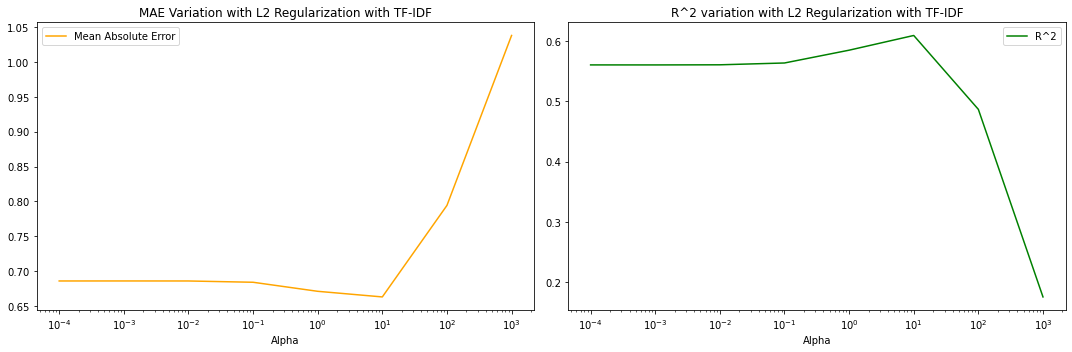

In [88]:
regression_plots(scores, 'L2 Regularization with TF-IDF')

In [89]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train_scaled, y_train)
fitted_values = bound_predict(ridge_reg.predict(X_train_scaled))
print(custom_mae_scorer_func(y_train, fitted_values))
print(custom_r2_scorer_func(y_train, fitted_values))

0.5768973615220478
0.7032113718134783


In [90]:
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_test_scaled, y_test)
fitted_values = bound_predict(ridge_reg.predict(X_test_scaled))
print(custom_mae_scorer_func(y_test, fitted_values))
print(custom_r2_scorer_func(y_test, fitted_values))

0.5659540117424403
0.7282444184573854


In [91]:
tokens = [column for column in X_train_scaled.columns if 'review__' in column]
len(tokens)

2246

In [92]:
first_token_index = X_train_scaled.columns.get_loc(tokens[0])
first_token_index

53

In [93]:
token_coef_df = pd.DataFrame({'coefficient': [ridge_reg.coef_[i] for i in range(first_token_index,
                                                                                      X_train_scaled.shape[1],1)],
                             'token': pd.Series(tokens).str.replace('review__', '')}).sort_values("coefficient", ascending=False)

token_coef_df.head()

,coefficient,token
935,1.157691,great
257,1.147008,best
603,1.058142,delici
1198,0.858704,love
129,0.814504,amaz


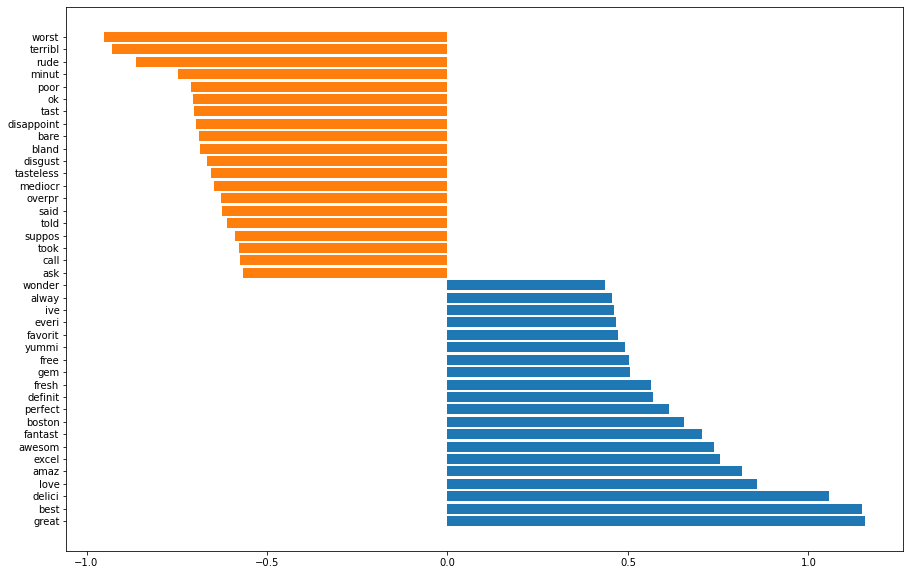

In [94]:
plt.figure(figsize=(15,10))
plt.barh(token_coef_df['token'].head(20),token_coef_df.head(20)["coefficient"])
plt.barh(token_coef_df['token'].tail(20),token_coef_df.tail(20)["coefficient"])

plt.show()

In [95]:
%%time

scores = pd.DataFrame(columns=['n_estimators', 'MAE', 'R-squared'])

for n in range(100, 102, 25):
    forest_reg = RandomForestRegressor(n_estimators=n, max_depth = 25, min_samples_leaf = 6)

    
    cv_scores = cross_validate(forest_reg, X_train_unscaled, y_train, cv=5,
                               scoring=scorer)

    scores = scores.append({'n_estimators': n,
                                    'MAE': np.mean(-cv_scores['test_custom_mae_scorer']),
                                    'R-squared': np.mean(cv_scores['test_custom_r2_scorer'])}, ignore_index=True)
    
    
scores

KeyboardInterrupt: 

In [57]:
%%time

forest_reg = RandomForestRegressor()

param_grid = [{'max_depth': [20, 25, 30], 'min_samples_leaf': [2, 4], 'n_estimators': [75, 100, 125]}]

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring=scorer, refit='custom_mae_scorer', verbose=4)

grid_search.fit(X_train_unscaled, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END max_depth=20, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.773) custom_r2_scorer: (test=0.479) total time= 2.3min
[CV 2/5] END max_depth=20, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.795) custom_r2_scorer: (test=0.447) total time= 2.3min
[CV 3/5] END max_depth=20, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.786) custom_r2_scorer: (test=0.473) total time= 2.3min
[CV 4/5] END max_depth=20, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.752) custom_r2_scorer: (test=0.504) total time= 2.2min
[CV 5/5] END max_depth=20, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.761) custom_r2_scorer: (test=0.487) total time= 2.3min
[CV 1/5] END max_depth=20, min_samples_leaf=2, n_estimators=100; custom_mae_scorer: (test=-0.773) custom_r2_scorer: (test=0.480) total time= 2.9min
[CV 2/5] END max_depth=20, min_samples_leaf=2, n_estimat

[CV 2/5] END max_depth=25, min_samples_leaf=4, n_estimators=125; custom_mae_scorer: (test=-0.781) custom_r2_scorer: (test=0.462) total time= 4.2min
[CV 3/5] END max_depth=25, min_samples_leaf=4, n_estimators=125; custom_mae_scorer: (test=-0.776) custom_r2_scorer: (test=0.488) total time= 4.0min
[CV 4/5] END max_depth=25, min_samples_leaf=4, n_estimators=125; custom_mae_scorer: (test=-0.738) custom_r2_scorer: (test=0.516) total time= 4.1min
[CV 5/5] END max_depth=25, min_samples_leaf=4, n_estimators=125; custom_mae_scorer: (test=-0.749) custom_r2_scorer: (test=0.502) total time= 4.1min
[CV 1/5] END max_depth=30, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.740) custom_r2_scorer: (test=0.510) total time= 3.0min
[CV 2/5] END max_depth=30, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.768) custom_r2_scorer: (test=0.471) total time= 3.0min
[CV 3/5] END max_depth=30, min_samples_leaf=2, n_estimators=75; custom_mae_scorer: (test=-0.759) custom_r2_scorer:

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [20, 25, 30], 'min_samples_leaf': [2, 4],
                          'n_estimators': [75, 100, 125]}],
             refit='custom_mae_scorer',
             scoring={'custom_mae_scorer': make_scorer(custom_mae_scorer_func, greater_is_better=False),
                      'custom_r2_scorer': make_scorer(custom_r2_scorer_func)},
             verbose=4)

In [58]:
grid_search.best_params_

{'max_depth': 30, 'min_samples_leaf': 2, 'n_estimators': 125}

In [60]:
best_forest_reg = grid_search.best_estimator_
best_forest_reg

RandomForestRegressor(max_depth=30, min_samples_leaf=2, n_estimators=125)

0.4183062633562634
0.8394350375949323


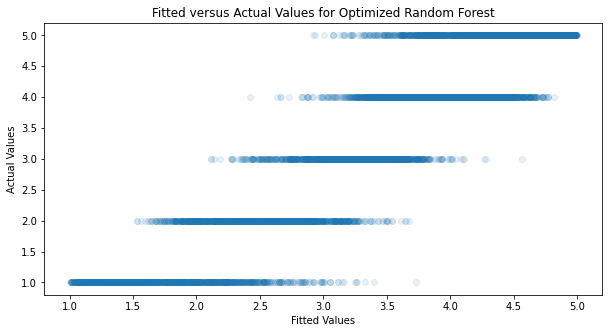

In [61]:
%%time

best_forest_reg.fit(X_train_unscaled, y_train)
fitted_values = bound_predict(best_forest_reg.predict(X_train_unscaled))
print(mean_absolute_error(y_train, fitted_values))
print(r2_score(y_train, fitted_values))
plot_fitted_values(fitted_values, y_train, 'Optimized Random Forest')

0.7347719523064744
0.5210542469631001


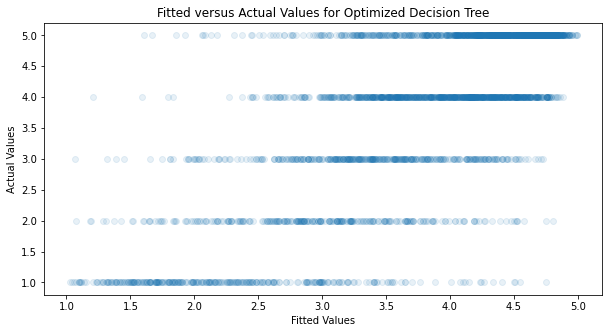

In [62]:
fitted_values = bound_predict(best_forest_reg.predict(X_test_unscaled))
print(mean_absolute_error(y_test, fitted_values))
print(r2_score(y_test, fitted_values))
plot_fitted_values(fitted_values, y_test, 'Optimized Decision Tree')